In [2]:
import numpy as np
import os, copy, time, json, cv2, random
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive
import torchvision.transforms as T
from torchsummary import summary

import detectron2
from detectron2        import model_zoo
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader, build_detection_train_loader
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from tqdm.notebook import tqdm, trange

import pandas as pd

# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

mz = _ModelZooUrls()
# print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

torch:  2.1 ; cuda:  cu121


In [7]:
def get_stone_dict(fp, filename):
  fn = os.path.join(fp, filename)
  with open(fn) as f:
    data = json.load(f)

  dataset_dicts = []

  for img in data['images']:
    record = {}

    filename = os.path.basename(img["file_name"]).replace(":", "_")
    filename = os.path.join(fp, filename)

    # print(filename)
      
    record["file_name"] = filename
    record["image_id"] = img['id']
    record["height"] = img['height']
    record["width"] = img['width']

    objs = []
    for anno in data['annotations']:
      if anno['image_id'] == record["image_id"]:
        obj = {
            "bbox" : anno['bbox'],
            # "bbox_mode": BoxMode.XYWH_ABS,
            "bbox_mode" : BoxMode.XYXY_ABS,
            "segmentation": anno['segmentation'],
            "category_id": 0,
            # anno['category_id'],
            "iscrowd": 0,

        }

        objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts

In [8]:
# coco-segmentation/train/_annotations.coco.json
dataset_directory = "coco-segmentation"
content = os.listdir(dataset_directory)

dataset_catalog_name_train = "stone_train"
dataset_catalog_name_valid = "stone_val"

try:
    DatasetCatalog.pop(dataset_catalog_name_train)
except:
    pass

try:
    DatasetCatalog.pop(dataset_catalog_name_valid)
except:
    pass

dataset_train_pwd = os.path.join(dataset_directory, 'train')
dataset_valid_pwd = os.path.join(dataset_directory, 'valid')

try:
    DatasetCatalog.register(dataset_catalog_name_train, lambda : get_stone_dict(dataset_train_pwd, '_annotations.coco.json'))
except:
    print(f'Probably data {traint_dataset_pwd} have been already registred')

try:
    DatasetCatalog.register(dataset_catalog_name_valid, lambda : get_stone_dict(dataset_valid_pwd, '_annotations.coco.json'))
except:
    print(f'Probably data {traint_dataset_val_pwd} have been already registred')

In [9]:
MetadataCatalog.get(dataset_catalog_name_train).set(thing_classes=["stone"])
MetadataCatalog.get(dataset_catalog_name_valid).set(thing_classes=["stone"])

namespace(name='stone_val', thing_classes=['stone'])

In [10]:
stone_train_metadata = MetadataCatalog.get("stone_train")
dataset_train_dicts = get_stone_dict(dataset_train_pwd, '_annotations.coco.json')


### Check out

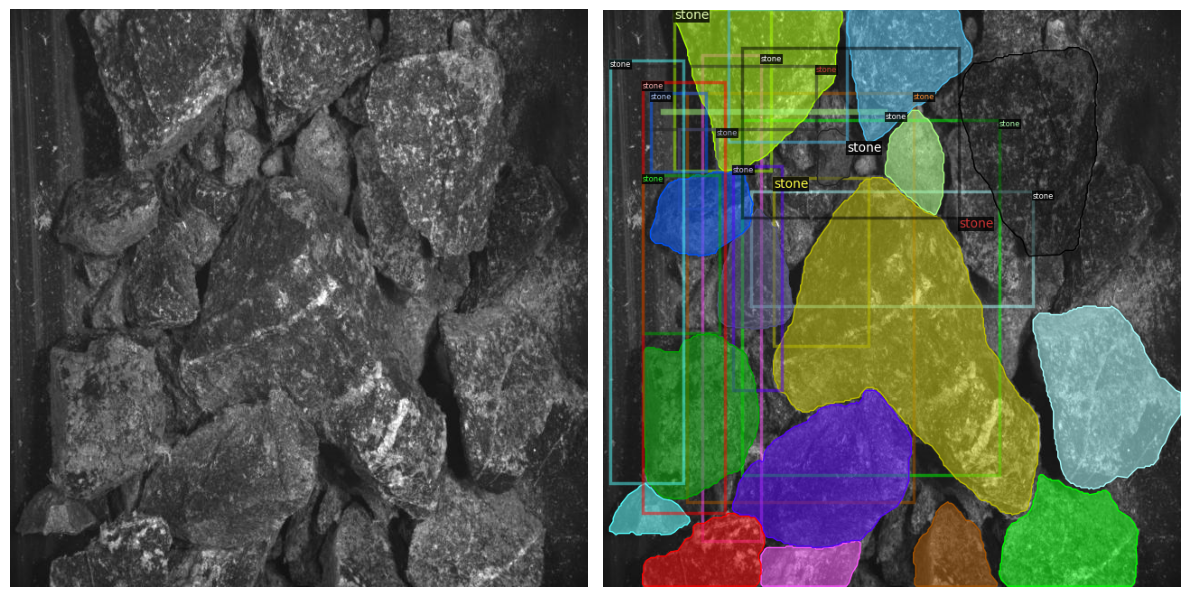

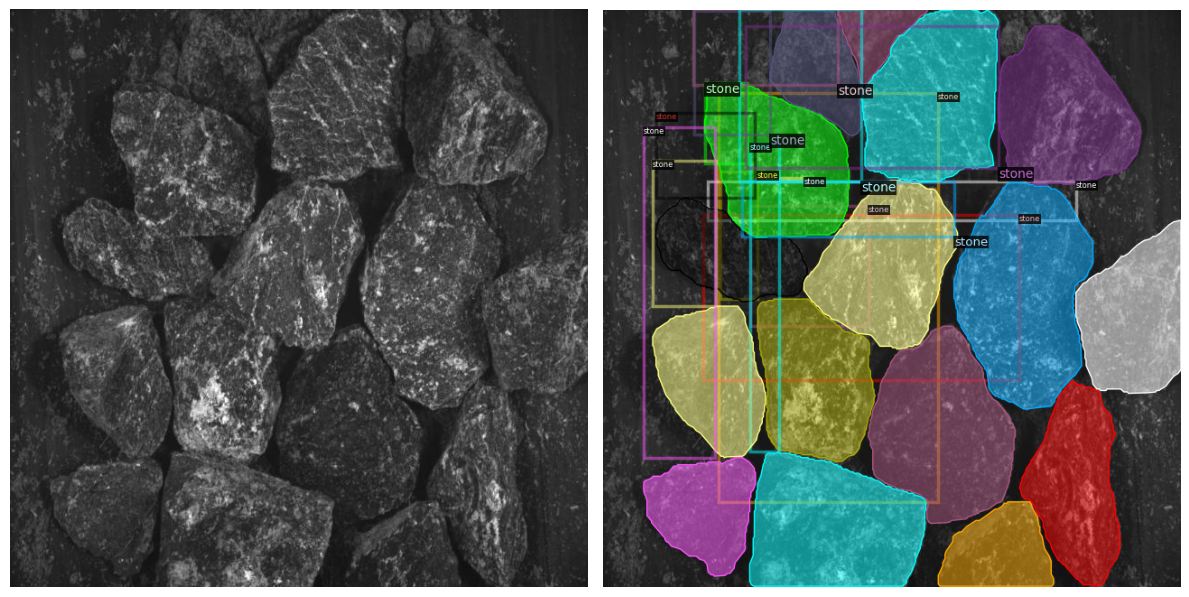

In [11]:

dataset_train_dicts = get_stone_dict(dataset_train_pwd, '_annotations.coco.json')

for d in random.sample(dataset_train_dicts, 2):
    img   = Image.open(d["file_name"])
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(img); axs[0].axis('off')
    visualizer = Visualizer(img, metadata=stone_train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

# Train

In [12]:
import detectron2.data.transforms as T

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
                        T.Resize((800,600)),
                        T.RandomBrightness(0.8, 1.8),
                        T.RandomContrast(0.6, 1.3),
                        T.RandomSaturation(0.8, 1.4),
                        T.RandomRotation(angle=[90, 90]),
                        T.RandomLighting(0.7),
                        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict



### Config

In [13]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("stone_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

### Multiprocessing

In [14]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [126]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

[11/30 11:08:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

# TRAIN IT

In [127]:
trainer.train()

[11/30 11:08:31 d2.engine.train_loop]: Starting training from iteration 0
[11/30 11:08:40 d2.utils.events]:  eta: 0:05:20  iter: 19  total_loss: 7.247  loss_cls: 0.6223  loss_box_reg: 0.7589  loss_mask: 0.6811  loss_rpn_cls: 4.243  loss_rpn_loc: 0.8207    time: 0.3265  last_time: 0.3281  data_time: 0.1219  last_data_time: 0.0055   lr: 4.9953e-06  max_mem: 2309M
[11/30 11:08:46 d2.utils.events]:  eta: 0:05:14  iter: 39  total_loss: 5.302  loss_cls: 0.6194  loss_box_reg: 0.7643  loss_mask: 0.6739  loss_rpn_cls: 2.485  loss_rpn_loc: 0.8108    time: 0.3268  last_time: 0.3240  data_time: 0.0054  last_data_time: 0.0051   lr: 9.9902e-06  max_mem: 2309M
[11/30 11:08:53 d2.utils.events]:  eta: 0:05:08  iter: 59  total_loss: 4.064  loss_cls: 0.6029  loss_box_reg: 0.8006  loss_mask: 0.6636  loss_rpn_cls: 1.295  loss_rpn_loc: 0.8097    time: 0.3271  last_time: 0.3283  data_time: 0.0052  last_data_time: 0.0052   lr: 1.4985e-05  max_mem: 2309M
[11/30 11:09:00 d2.utils.events]:  eta: 0:05:01  iter: 7

# METRICS

In [102]:
#import json
#metrics = os.path.join(cfg.OUTPUT_DIR, "metrics.json")

#with open(metrics, mode='r') as f:
#    m_data = json.load(f)

#m_data

# VALIDATE

In [15]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("stone_valid")
predictor = DefaultPredictor(cfg)


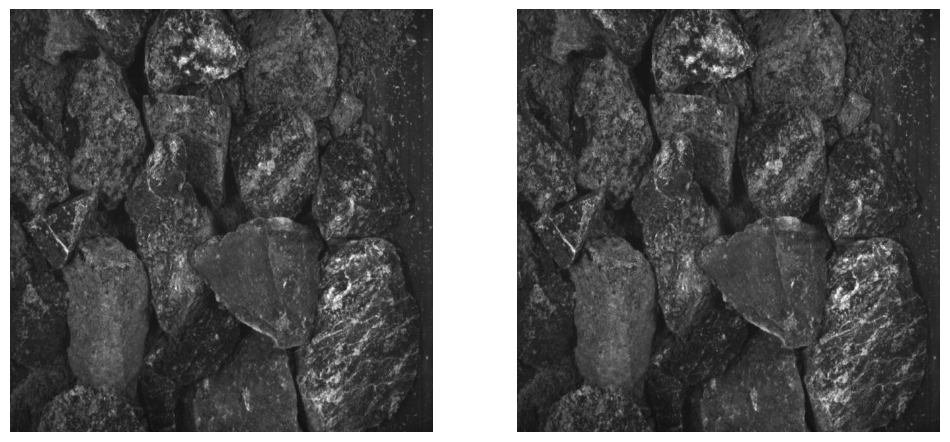

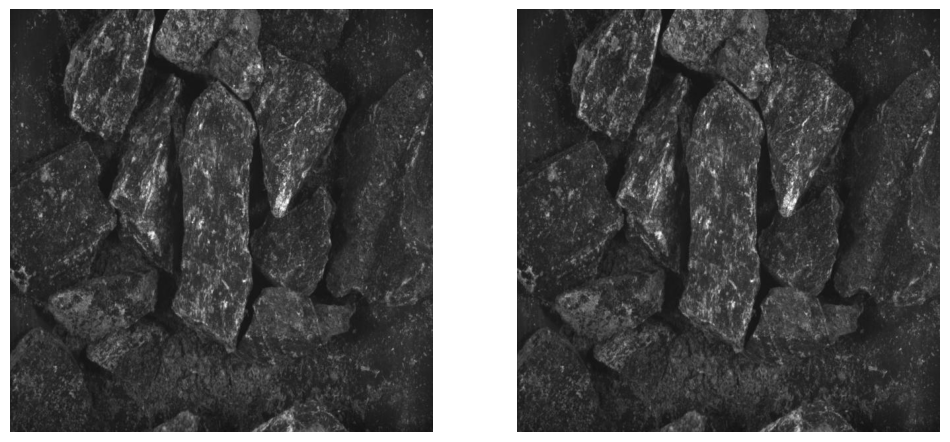

In [20]:
stone_valid_metadata = MetadataCatalog.get("stone_valid")
dataset_valid_dicts = get_stone_dict(dataset_valid_pwd, '_annotations.coco.json')

for d in random.sample(dataset_valid_dicts, 2):
    img   = cv2.imread(d["file_name"])
    
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(img); axs[0].axis('off')

    outputs = predictor(img)
    # print(outputs)
    v = Visualizer(img, 
                    metadata=stone_valid_metadata, 
                    scale=1
                  )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    axs[1].imshow(out.get_image()); 
    axs[1].axis('off');

plt.show()